In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import time
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

In [4]:
 #function for wrangling our data, loading and processing our data  
def wrangle(filepath,resample_rule="1H"):
  #reading data
  df=pd.read_csv(filepath)
  #filtering only city of Ahmedabad since it has largest observation
  df_mask= df["City"] =="Ahmedabad"
  df=df[df_mask]
  # for this project only intersted in value of pm2.5
  df=df.drop(columns=['City', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],axis=1)
  #changing datetime to its format
  df['Datetime'] = pd.to_datetime(df['Datetime'])
  # setting index to datetime
  df= df.set_index("Datetime")
  #localize timezone                                 
  df.index =df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
  #removing outliers in PM2.5 reading
  df=df[df["PM2.5"]<800]
  #removing null values and 
  y = df["PM2.5"].resample("1H").mean().fillna(method='ffill')
  y.dropna()

  
  return y


In [5]:
#specifying our data path
y= wrangle("/content/drive/MyDrive/air quality/city_hour.csv",resample_rule="1H")
y.tail()

Datetime
2020-07-01 01:00:00+05:30    42.92
2020-07-01 02:00:00+05:30    44.41
2020-07-01 03:00:00+05:30    33.68
2020-07-01 04:00:00+05:30    56.86
2020-07-01 05:00:00+05:30    37.63
Freq: H, Name: PM2.5, dtype: float64

Text(0, 0.5, 'Correlation Cofficient')

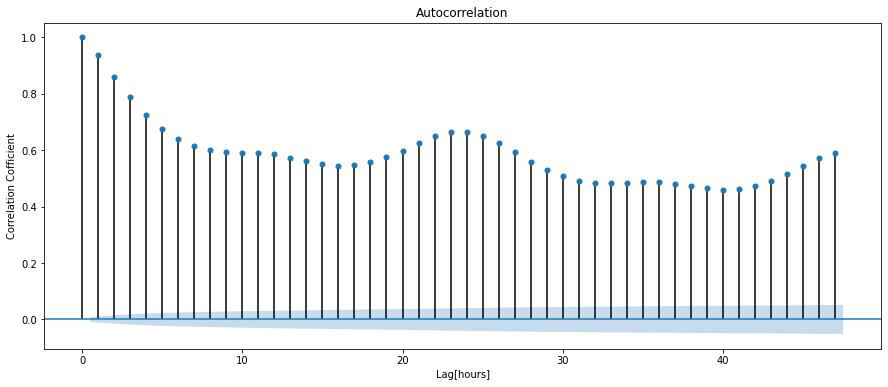

In [6]:
#create acf plot for y
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(y,ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Cofficient")

Text(0, 0.5, 'Correlation Cofficient')

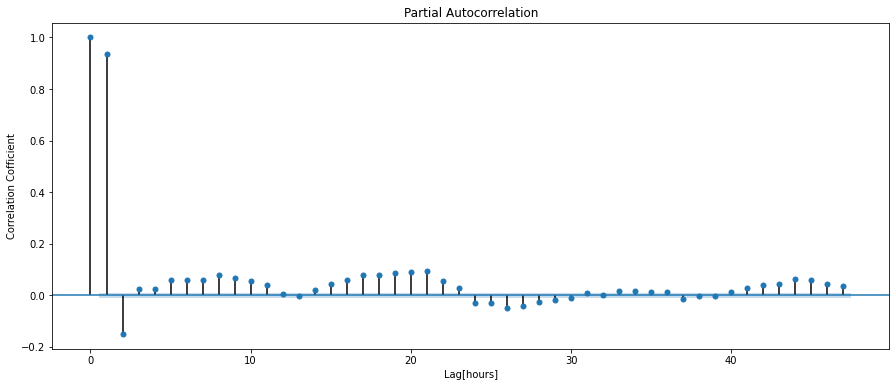

In [7]:
#creating pacf plot
fig,ax=plt.subplots(figsize=(15,6))
plot_pacf(y,ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Cofficient")

In [8]:
#creating a training and a test set 
y_train = y.loc["2018-10-1":"2018-10-31"]
y_test = y.loc["2018-11-1"] 

#building Baseline Model

In [9]:
y_train_mean=y_train.mean()
y_mean_pred=[y_train_mean]*len(y_train)
mae_baseline =mean_absolute_error(y_train,y_mean_pred)
print("Mean PM2.5 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean PM2.5 Reading: 95.07
Baseline MAE: 37.45


In [16]:
#Create ranges for possible  𝑝  and  𝑞  values. 
p_params = range(0,25,8)
q_params = range(0,3,1)
list(p_params)

[0, 8, 16, 24]

In [17]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.13 seconds.
Trained ARIMA (0, 0, 1) in 0.24 seconds.
Trained ARIMA (0, 0, 2) in 0.34 seconds.
Trained ARIMA (8, 0, 0) in 1.22 seconds.
Trained ARIMA (8, 0, 1) in 1.05 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (8, 0, 2) in 3.85 seconds.
Trained ARIMA (16, 0, 0) in 4.63 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (16, 0, 1) in 11.48 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (16, 0, 2) in 30.83 seconds.
Trained ARIMA (24, 0, 0) in 18.16 seconds.
Trained ARIMA (24, 0, 1) in 24.98 seconds.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Trained ARIMA (24, 0, 2) in 28.83 seconds.

{0: [37.44619019918052, 25.574940922044345, 21.52850667477855], 8: [17.23363830725766, 17.233916052251136, 17.205230727232312], 16: [17.058977852742018, 16.463313186497405, 576985388.3423218], 24: [16.399093391068167, 16.431049131584857, 16.43155214788541]}


In [28]:
# organize all MAE values in dataframe
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)


,0,8,16,24
0,37.4462,17.2336,1.705900e+01,16.3991
1,25.5749,17.2339,1.646330e+01,16.4310
2,21.5285,17.2052,5.769854e+08,16.4316


Text(0.5, 1.0, 'ARMA grid search')

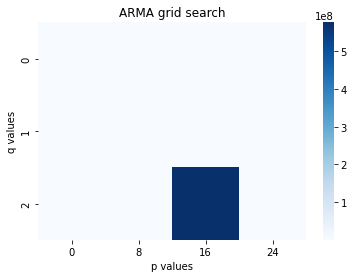

In [21]:
# heatmap to visualizing the above
sns.heatmap(mae_df,cmap='Blues')
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA grid search')

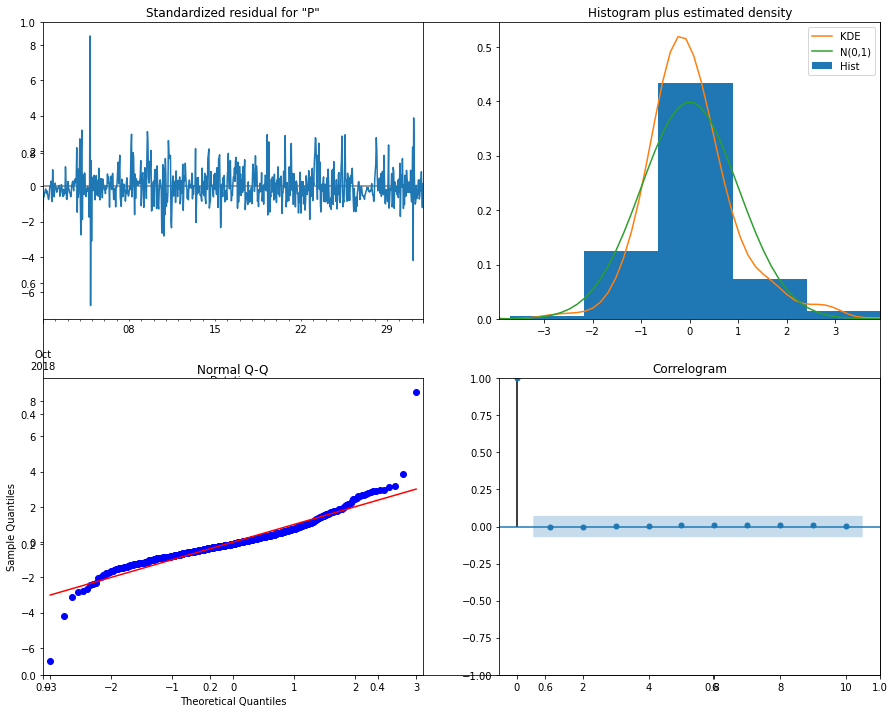

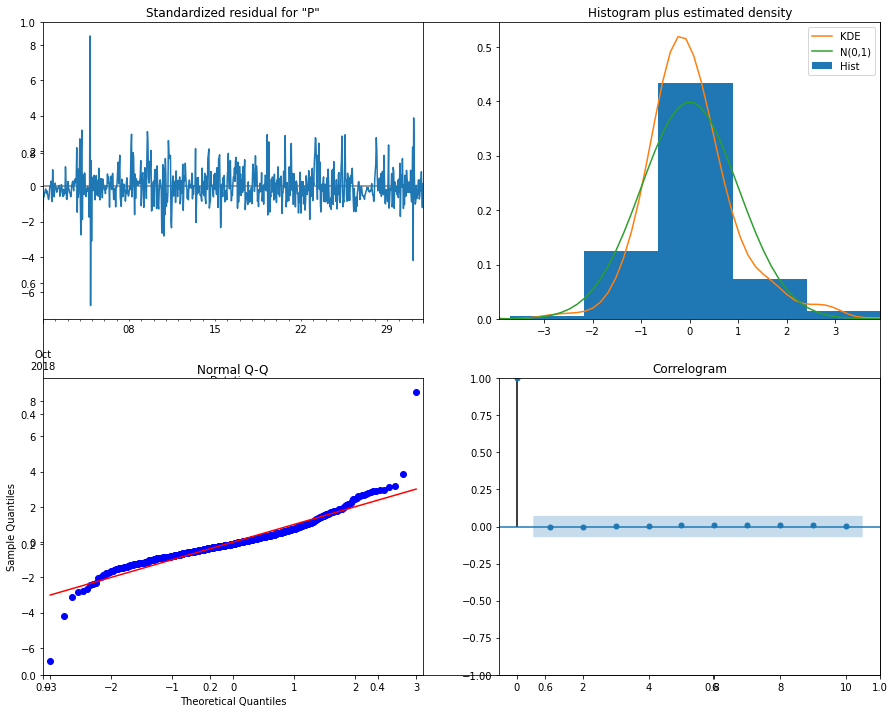

In [22]:
# useing plot diagnostics to check our risiduals
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)

In [23]:
# prediction 
#prediction using walk forward validation for our test_set
y_pred_wfv=pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history,order=(8,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
test_mae =mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 11.98


In [30]:
f_pred_test =pd.DataFrame(
{
    "y_test":y_test,"y_pred_wfv":y_pred_wfv
})
fig = px.line(f_pred_test,labels={'value':"PM2.5"})
fig.show()